In [60]:
from dataset import *
from model import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
import numpy as np
from scipy.spatial.distance import cosine, euclidean
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr, entropy


In [61]:
seed = 10
batch_size = 1
num_slots = 5
num_iterations = 3
resolution = (32, 32)

model = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations, 64)
model.load_state_dict(torch.load('ckpts/model_370.ckpt')['model_state_dict'])
model = model.to(device)


test_set = CustomDataset("1000_nopick_pixel_states.npy")


/tmp/ipykernel_1528/3615093354.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpts/model_370.ckpt')['model_state_dict'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08737949..1.073063].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.087377205..1.0730374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037741754..1.0277581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.99742985..1.0024681].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.99303985..1.0024163].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028965719..1.0177354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

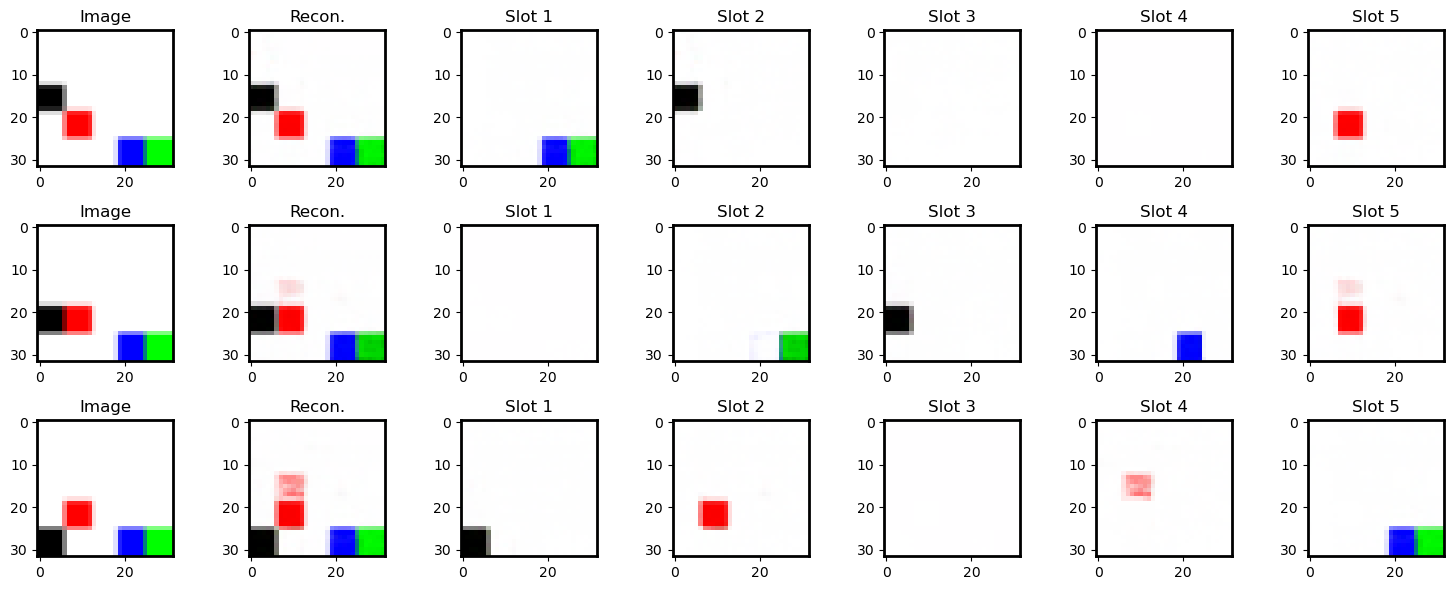

In [62]:
num_images = 3

fig, axs = plt.subplots(num_images, num_slots + 2, figsize=(15, 2 * num_images))

# Loop over the first 10 images.
for idx in range(num_images):
    # Get the image and prepare it.
    image = test_set[idx]['image']
    image = image.unsqueeze(0).to(device)
    
    # Get model outputs.
    recon_combined, recons, masks, slots = model(image)
    
    # Remove batch dimension and convert to numpy arrays.
    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    recon_combined_np = recon_combined.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    recons_np = recons.squeeze(0).cpu().detach().numpy()
    masks_np = masks.squeeze(0).cpu().detach().numpy()
    
    # Plot the original image.
    axs[idx, 0].imshow(image_np)
    axs[idx, 0].set_title('Image')
    
    # Plot the combined reconstruction.
    axs[idx, 1].imshow(recon_combined_np)
    axs[idx, 1].set_title('Recon.')
    
    # Plot each slot's output.
    for i in range(num_slots):
        # Combine the slot reconstruction with its mask.
        picture = recons_np[i] * masks_np[i] + (1 - masks_np[i])
        axs[idx, i + 2].imshow(picture)
        axs[idx, i + 2].set_title(f'Slot {i+1}')
    
    # Remove gridlines and axes for the current row and add a border.
    for ax in axs[idx]:
        ax.grid(False)
        ax.axis('on')
        
        # Add a visible border
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # Set border color
            spine.set_linewidth(2)        # Set border thickness

plt.tight_layout()
plt.show()


In [63]:
image1 = test_set[0]['image'].unsqueeze(0).to(device)
image2 = test_set[1]['image'].unsqueeze(0).to(device)
image3 = test_set[2]['image'].unsqueeze(0).to(device)

In [64]:
_, _, _, slots1 = model(image1)
_, _, _, slots2 = model(image2)
_, _, _, slots3 = model(image3)

slots1 = slots1.squeeze(0).cpu().detach().numpy()
slots2 = slots2.squeeze(0).cpu().detach().numpy()
slots3 = slots3.squeeze(0).cpu().detach().numpy()

In [65]:
def compute_similarity_metrics(array1: np.ndarray, array2: np.ndarray) -> dict:
    """
    Computes 5 similarity metrics between two 8x8x64 arrays.
    
    Args:
        array1 (np.ndarray): First array of shape (8, 8, 64)
        array2 (np.ndarray): Second array of shape (8, 8, 64)
    
    Returns:
        dict: Dictionary containing similarity scores for cosine similarity,
              Euclidean distance, SSIM, Pearson correlation, and Jensen-Shannon divergence.
    """
    
    # Flatten arrays
    vec1 = array1.flatten()
    vec2 = array2.flatten()
    
    # Compute cosine similarity
    cosine_sim = 1 - cosine(vec1, vec2)
    
    # Compute Euclidean distance
    euclidean_dist = euclidean(vec1, vec2)
    
    # Compute Structural Similarity Index (SSIM) per channel and average
    ssim_score = np.mean([ssim(array1[:, :, i], array2[:, :, i], data_range=array1.max() - array1.min()) for i in range(64)])
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(vec1, vec2)
    
    # Compute Jensen-Shannon divergence
    p = np.abs(vec1) / np.sum(np.abs(vec1))  # Convert to probability distribution
    q = np.abs(vec2) / np.sum(np.abs(vec2))  # Convert to probability distribution
    js_divergence = 0.5 * (entropy(p, (p + q) / 2) + entropy(q, (p + q) / 2))
    
    return {
        "cosine_similarity": cosine_sim,
        "euclidean_distance": euclidean_dist,
        "ssim": ssim_score,
        "pearson_correlation": pearson_corr,
        "jensen_shannon_divergence": js_divergence
    }

In [66]:
for i, sl in enumerate(slots2):
    sim = compute_similarity_metrics(slots1[1], sl)
    print(f"Slot {i + 1} for image 2 ")
    print(sim)

Slot 1 for image 2 
{'cosine_similarity': np.float32(0.19130862), 'euclidean_distance': 209.8169708251953, 'ssim': np.float64(0.01938463284750469), 'pearson_correlation': np.float32(0.15868646), 'jensen_shannon_divergence': np.float32(0.17983346)}
Slot 2 for image 2 
{'cosine_similarity': np.float32(0.9973119), 'euclidean_distance': 15.17177963256836, 'ssim': np.float64(0.9803813844919205), 'pearson_correlation': np.float32(0.99722373), 'jensen_shannon_divergence': np.float32(0.001665734)}
Slot 3 for image 2 
{'cosine_similarity': np.float32(0.120954216), 'euclidean_distance': 222.07875061035156, 'ssim': np.float64(-0.010106365429237485), 'pearson_correlation': np.float32(0.1004632), 'jensen_shannon_divergence': np.float32(0.17412198)}
Slot 4 for image 2 
{'cosine_similarity': np.float32(0.3198074), 'euclidean_distance': 204.767822265625, 'ssim': np.float64(0.17392563739122124), 'pearson_correlation': np.float32(0.30037528), 'jensen_shannon_divergence': np.float32(0.17710727)}
Slot 5 f